In [372]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [373]:
# 加载数据

def load_data(data_dir):
    images = []
    labels = []
    # 遍历人脸数据集中的每个人的文件夹，list_dir()返回指定目录下的文件和文件夹列表
    for person_dir in os.listdir(data_dir):
        if not person_dir.startswith('s'):
            continue
        person_id = int(person_dir.replace('s', ''))
        label = person_id-1
        person_path = os.path.join(data_dir, person_dir)

        for filename in os.listdir(person_path):
            if not filename.endswith('.pgm'):
                continue
            image_path = os.path.join(person_path, filename)
            # 以灰度图像读入,pgm文件是灰度图像
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            img = img.flatten()
            images.append(img)
            labels.append(label)

    images = np.array(images) # 400*pic
    labels = np.array(labels) # 400*pic
    return images, labels

In [374]:
# 划分数据集
def split_data(images, labels,split_ratio=0.7):
    n_samples, n_features = images.shape
    n_train = int(0.7*n_samples)  # 70%作为训练集
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    # 按类别划分数据集(分层抽样)
    for label in np.unique(labels):
        idx = np.where(labels == label)[0]
        train_idx = idx[:int(split_ratio*len(idx))]
        test_idx = idx[int(split_ratio*len(idx)):]
        train_images.append(images[train_idx]) # 每个元素大小是7*pic
        train_labels.append(labels[train_idx])
        test_images.append(images[test_idx]) # 每个元素大小是3*pic
        test_labels.append(labels[test_idx])

    train_images = np.array(train_images) # 40*7*pic
    train_labels = np.array(train_labels)
    test_images = np.array(test_images) # 40*3*pic
    test_labels = np.array(test_labels)

    train_images = train_images.reshape((-1, n_features)) # 280*pic
    train_labels = train_labels.reshape((-1)) # 280
    test_images = test_images.reshape((-1, n_features)) # 120*pic
    test_labels = test_labels.reshape((-1)) # 120
    
    # print(train_images.shape, train_labels.shape,
    #       test_images.shape, test_labels.shape)
    return train_images, train_labels, test_images, test_labels

In [375]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.components = None

    def transform(self, X):
        Xc = X - self.mean
        # 280*pic @ pic*n_components = 280*n_components

        return Xc.dot(self.eigenvectors)
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)  # axis=0表示按列求均值

        Xc = X-self.mean  # 中心化280*pic

        # 计算协方差矩阵,Xc.shape[0]-1是为了得到无偏估计
        # cov_matrix = Xc.T@Xc/(Xc.shape[0]-1)

        # eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)  # 计算特征值和特征向量

        n,d=Xc.shape

        # 尝试使用SVD加速运算
        U,S,Vt=np.linalg.svd(Xc,full_matrices=False)#U:280*280,S:280*280,Vt:280*pic

        eigenvalues=S**2/(n-1)#计算特征值
        eigenvectors=Vt.T#计算特征向量 pic*280

        # 对特征向量排序
        # argsort()返回的是数组值从小到大的索引值，[::-1]两个冒号表示逆序
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        self.eigenvalues = eigenvalues[:self.n_components]
        self.eigenvectors = eigenvectors[:, :self.n_components]

        # 转换特征向量到原始空间
        
        
        #eigenvectors[:, :self.n_components] pic*n_components
        #Xc 280*pic
        #self.components 280*n_components

        self.eigenvectors = self.eigenvectors / \
            np.linalg.norm(self.eigenvectors, axis=0)  # 归一化
        
        self.components = self.transform(Xc)
        return self

    
    # 计算累计方差贡献率
    def compute_cumulative_variance(self):
        total = self.eigenvalues.sum()
        cumulative = np.cumsum(self.eigenvalues)
        return np.where(cumulative >= 0.95*total)[0][0]+1
    
    # 重构人脸
    def reconstruct(self, X,k):
        Xc = X - self.mean # 280*pic
        eigenvectors = self.eigenvectors[:,:k]#pic*k
        reconstructed = Xc.dot(eigenvectors).dot(eigenvectors.T)+self.mean
        return reconstructed.reshape(-1,112,92)
    
    # 绘制特征脸（前10个）
    def plot_eigenfaces(self):
        fig, axes = plt.subplots(2, 5, figsize=(10, 4),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes.flat):
            ax.imshow(self.eigenvectors[:, i].reshape(112, 92), cmap='gray')
            ax.set_title(f'Eigenface {i+1}')
        plt.show()

    # 绘制重构人脸（前10个）
    def plot_reconstructed_faces(self, X,k):
        reconstructed = self.reconstruct(X,k)
        fig, axes = plt.subplots(2, 5, figsize=(10, 4),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes.flat):
            ax.imshow(reconstructed[i], cmap='gray')
            ax.set_title(f'Pic {i+1}')
        plt.show()

    def predict(self,test_images,train_images,train_labels):
        train_images_pca = self.transform(train_images)
        test_images_pca = self.transform(test_images)
        # print(train_images_pca.shape)
        knn=KNeighborsClassifier(n_neighbors=1)
        knn.fit(train_images_pca,train_labels)
        test_images_pca=self.transform(test_images)
        pred=knn.predict(test_images_pca)
        return pred


In [376]:
data_dir = 'D:/codes/.vscode/NLP/att_faces.tar/att_faces/orl_faces'
images, labels = load_data(data_dir)
images = images/255.0
split_ratio = 0.8
train_images, train_labels, test_images, test_labels = split_data(
    images, labels, split_ratio)


In [377]:
n_components = 240
pca = PCA(n_components=n_components)

pca.fit(train_images)

train_images_pca = pca.transform(train_images)
test_images_pca = pca.transform(test_images)


In [378]:
pred=pca.predict(test_images,train_images,train_labels)
accuracy=accuracy_score(test_labels,pred)
print('Accuracy of PCA:', accuracy)

Accuracy of PCA: 0.95


特征脸可视化

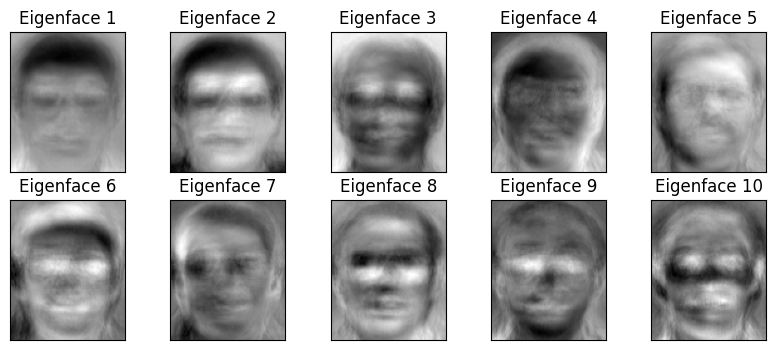

In [379]:
pca.plot_eigenfaces()

人脸重建

136


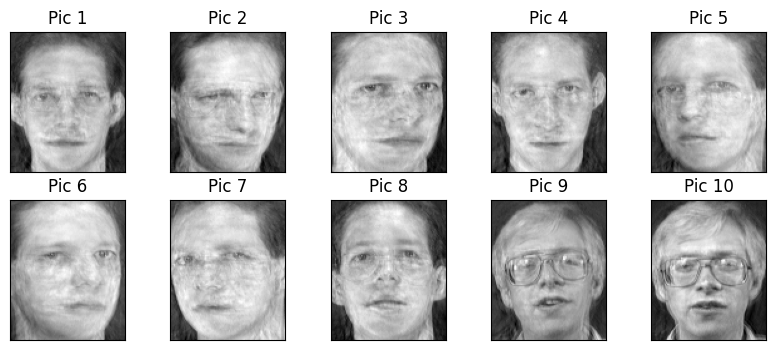

In [380]:
k=pca.compute_cumulative_variance()
print(k)
pca.plot_reconstructed_faces(train_images, k)

使用FLD算法预测

In [381]:
class FLD:
    def __init__(self,n_components=None):
        self.n_components=n_components  
        self.w=None

    def fit(self,X,y):
        classes=np.unique(y)
        n_features=X.shape[1]
        S_W=np.zeros((n_features,n_features))

        for cls in classes:
            idx=np.where(cls==y)
            X_cls=X[idx]
            mean_cls=np.mean(X_cls,axis=0)
            S_cls=np.dot((X_cls-mean_cls).T,X_cls-mean_cls)
            S_W+=S_cls
        S_W+=np.eye(n_features)
        mu_all=np.mean(X,axis=0)
        S_B=np.zeros((n_features,n_features))

        for cls in classes:
            idx=np.where(cls==y)[0]
            X_cls=X[idx]
            mu_cls=np.mean(X_cls,axis=0)
            S_B += len(X_cls) * np.outer((mean_cls - mu_all), (mean_cls - mu_all))   

        S_B+=np.eye(n_features)*1e-2
        # print(np.linalg.inv(S_W))
        
        eigenvalues,eigenvectors=np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
        idx=eigenvalues.argsort()[::-1]
        eigenvalues=eigenvalues[idx]
        eigenvectors=eigenvectors[:,idx]
               

        self.w=eigenvectors[:,:self.n_components]

        # print(self.w.shape)
        return self

    def transform(self,X):
        return X.dot(self.w)
    
    def predict(self,test_images,train_images,train_labels):
        train_images_fld = self.transform(train_images)
        test_images_fld = self.transform(test_images)
        knn=KNeighborsClassifier(n_neighbors=1)
        knn.fit(train_images_fld,train_labels)
        test_images_fld=self.transform(test_images)
        pred=knn.predict(test_images_fld)
        return pred
    

        

In [382]:
fld=FLD(n_components=39)
fld.fit(train_images_pca,train_labels)
pred=fld.predict(test_images_pca,train_images_pca,train_labels)
accuracy=accuracy_score(test_labels,pred)
print('Accuracy of FLD:', accuracy)

Accuracy of FLD: 0.9625


k折交叉验证准确率

In [383]:
def k_fold_split(images,labels,k=5):
    fold_images=[[]for _ in range(k)]
    fold_label=[[]for _ in range(k)]

    for label in np.unique(labels):
        idx=np.where(labels==label)[0]
        # np.random.shuffle(idx)
        fold_size=len(idx)//k
        

        for i in range(k):
            start=i*fold_size
            end=(i+1)*fold_size if i!=k-1 else len(idx)
            fold_images[i].append(images[idx[start:end]])
            fold_label[i].append(labels[idx[start:end]])

    fold_images=np.array(fold_images)
    fold_label=np.array(fold_label)
    return fold_images,fold_label

In [384]:
def cross_validate(images,labels,k=5):
    fold_images,fold_labels=k_fold_split(images,labels,k)
    # print(fold_images.shape,fold_labels.shape)
    PCA_scores=[]
    PCA_FLD_scores=[]

    for i in range(k):
        val_images,val_labels=fold_images[i],fold_labels[i]
        train_images,train_labels=[],[]
        for j in range(k):
            if i!=j:
                train_images.append(fold_images[j])
                train_labels.append(fold_labels[j])

        train_images=np.reshape(train_images,(-1,images.shape[1]))
        val_images=np.reshape(val_images,(-1,images.shape[1]))
        train_labels=np.reshape(train_labels,(-1))
        val_labels=np.reshape(val_labels,(-1))

        pca=PCA(n_components=240)
        pca.fit(train_images)
        pred_labels=pca.predict(val_images,train_images,train_labels)
        accuracy=accuracy_score(val_labels,pred_labels)
        PCA_scores.append(accuracy)

        train_images_pca=pca.transform(train_images)
        # print(train_images_pca.shape)
        test_images_pca=pca.transform(val_images)
        fld=FLD(n_components=39)
        fld.fit(train_images_pca,train_labels)
        pred_labels=fld.predict(test_images_pca,train_images_pca,train_labels)
        accuracy=accuracy_score(val_labels,pred_labels)
        PCA_FLD_scores.append(accuracy)

    return PCA_scores,PCA_FLD_scores

images,labels=load_data(data_dir)
# print(images.shape,labels.shape)
PCA_scores,PCA_FLD_scores=cross_validate(images,labels,5)
print(PCA_scores,PCA_FLD_scores)
print('Mean accuracy of PCA:',np.mean(PCA_scores))
print('Mean accuracy of FLD:',np.mean(PCA_FLD_scores))


[0.9625, 1.0, 0.9125, 0.9875, 0.95] [0.95, 1.0, 0.9625, 0.975, 0.95]
Mean accuracy of PCA: 0.9625
Mean accuracy of FLD: 0.9675
